In [1]:
import pandas as pd
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Normalization
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.preprocessing import StandardScaler

# Load and Clean Data

In [2]:
building_raw = pd.read_csv('building_fire_risk.csv')
demo_raw = pd.read_csv('demographic_data/nyc_demographic_data.csv')
eco_raw = pd.read_csv('nyc_economic_data.csv')
fire_inc_all_raw = pd.read_csv('FireIncidenceAll.csv')
fire_inc_high_raw = pd.read_csv('HighRiskData.csv')
fire_inc_low_raw = pd.read_csv('LowRiskData.csv')

#### Demographic data (demo)

In [3]:
# Remove 'Total_Language_Population' column because all values are NaN and
# 'Median_Year_Built' because data is already captured in building data
demo = demo_raw.drop(['Total_Language_Population', 'Median_Year_Built'], axis=1)
demo.sample(5)

,ZIP,Total_Population,Median_Age,Male_Population,Female_Population,White,Black,American_Indian_Alaska_Native,Asian,Native_Hawaiian_Pacific_Islander,...,Not_in_Labor_Force,Employed,Unemployed,Median_Travel_Time,Total_With_Disability,No_Health_Insurance,Vehicles_Available,Foreign_Born,Median_Earnings,Households_with_Broadband
38,10128,57993,40.9,25068,32925,44069,2644,24,5364,0,...,36034,36034,1592,29859,57974,0,29698,13757,88584,27266
78,11101,32537,33.5,16539,15998,13324,4469,180,8631,13,...,20417,20417,1349,16215,32168,0,14951,12024,68429,13119
116,11234,90372,41.8,41955,48417,35078,40921,305,6725,0,...,44346,44331,2465,39049,90306,31,32227,33824,52631,28348
64,10462,75441,36.0,36382,39059,15651,20486,886,11793,18,...,38862,38846,3156,33575,75170,0,28981,24268,40234,24658
132,11365,43730,41.7,20451,23279,13423,3914,25,20085,12,...,21941,21941,1329,18892,43730,0,15702,20747,44422,13714


#### Building data (building)

In [4]:
# Assign risks to each zipcode
# high risk: 5, medium risk: 3, low risk: 1
building = building_raw.copy()
building = building.replace({'high':3, 'medium':2, 'low':1})

# Calculate total risk per zipcode
building['total_risk'] = building['risk'] * building['count']
build_risks = building.groupby('zipcode').sum()['total_risk']
building = building.merge(build_risks, on='zipcode', how='left').drop(['risk', 'count', 'total_risk_x'], axis=1).rename({'total_risk_y':'total_risk'}, axis=1)
building.drop_duplicates(inplace=True)

# Assign area_mile2 to zipcodes without value. Use minimum area_mile2 / 2
new_area_mile2 = building_raw.area_mile2.min() / 2
building.area_mile2 = building.area_mile2.fillna(new_area_mile2)

# Calculate average risk per zipcode
building['avg_build_risk'] = building.apply(lambda x: round(x['total_risk'] / x['area_mile2'], 3), axis=1)

# Keep useful columns and rename zipcode to ZIP to be consistent with other datasets
building = building[['zipcode', 'avg_build_risk']].rename({'zipcode': 'ZIP'}, axis=1)

building.sample(5)

C:\Users\kevin\AppData\Local\Temp\ipykernel_27004\2515830439.py:4: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  building = building.replace({'high':3, 'medium':2, 'low':1})


,ZIP,avg_build_risk
499,11378,10990.579
313,11201,7190.180
130,10105,4794.056
466,11366,8275.233
535,11420,18968.373


#### Economic data (eco)

In [5]:
eco = eco_raw.copy()
# Extract useful columns
eco = eco[['ZIP', 'est_households_total', 'est_households_median_income_dollars', 'est_households_mean_income_dollars', 
          'est_families_total', 'est_families_median_income_dollars', 'est_families_mean_income_dollars', 
          'est_married_couple_families_total', 'est_married_couple_families_median_income_dollars', 'est_married_couple_families_mean_income_dollars',
          'est_nonfamily_households_total', 'est_nonfamily_households_median_income_dollars', 'est_nonfamily_households_mean_income_dollars']]
eco.sample(5)

,ZIP,est_households_total,est_households_median_income_dollars,est_households_mean_income_dollars,est_families_total,est_families_median_income_dollars,est_families_mean_income_dollars,est_married_couple_families_total,est_married_couple_families_median_income_dollars,est_married_couple_families_mean_income_dollars,est_nonfamily_households_total,est_nonfamily_households_median_income_dollars,est_nonfamily_households_mean_income_dollars
119,11237,17723,82570.0,99019,8064,66514.0,93174,4671,87931.0,NaN,9659,85459,97510
27,10031,21991,65067.0,95724,10922,67889.0,100968,5442,90897.0,NaN,11069,55243,81827
75,10473,22734,50609.0,71363,14418,65656.0,83415,5183,96680.0,NaN,8316,27965,41543
35,10039,12427,48792.0,72337,6947,43798.0,71946,2129,72520.0,NaN,5480,55227,69427
143,11377,33371,73292.0,105205,19122,82230.0,121433,12796,93783.0,140638.0,14249,54282,72416


#### Fire Incident Data

In [6]:
# Extract useful columns
fire_inc_all = fire_inc_all_raw[['MODZCTA', 'Count']].rename({'MODZCTA':'ZIP', 'Count':'all_incident'}, axis=1)
fire_inc_low = fire_inc_low_raw[['MODZCTA', 'Count']].rename({'MODZCTA':'ZIP', 'Count':'low_incident'}, axis=1)
fire_inc_high = fire_inc_high_raw[['MODZCTA', 'Count']].rename({'MODZCTA':'ZIP', 'Count':'high_incident'}, axis=1)

In [7]:
# Combine all data and calculate medium risk incidents
inc = fire_inc_all.merge(fire_inc_low, on='ZIP', how='left')
inc = inc.merge(fire_inc_high, on='ZIP', how='left')
inc['med_incident'] = inc['all_incident'] - inc['high_incident'] - inc['low_incident']
inc.drop('all_incident', inplace=True, axis=1)

In [8]:
# Assign risks to each zipcode
risk_factor = {'high':3, 'medium':2, 'low':1}
inc['fire_incident_risk'] = inc['high_incident'] * risk_factor['high'] \
                            + inc['med_incident'] * risk_factor['medium'] \
                            + inc['low_incident'] * risk_factor['low']
# Drop 'low_incident', 'med_incident', 'high_incident' columns
inc = inc[['ZIP', 'fire_incident_risk']]
inc.sample(5)

,ZIP,fire_incident_risk
22,10026,10557
84,11103,5057
107,11220,12757
54,10312,9875
163,11426,2466


# Combine Data

In [9]:
# demo + building = df
df = demo.merge(building, on='ZIP')

# df + eco = df
df = df.merge(eco, on='ZIP')

# df + inc = df
df = df.merge(inc, on='ZIP')

df.sample(5)

,ZIP,Total_Population,Median_Age,Male_Population,Female_Population,White,Black,American_Indian_Alaska_Native,Asian,Native_Hawaiian_Pacific_Islander,...,est_families_total,est_families_median_income_dollars,est_families_mean_income_dollars,est_married_couple_families_total,est_married_couple_families_median_income_dollars,est_married_couple_families_mean_income_dollars,est_nonfamily_households_total,est_nonfamily_households_median_income_dollars,est_nonfamily_households_mean_income_dollars,fire_incident_risk
47,10307,15053,40.3,7630,7423,13834,17,0,691,0,...,3940,145521.0,178849,3450,148715.0,NaN,1195,62004,87310,2918
89,11206,87599,29.4,41953,45646,40492,19698,835,5629,187,...,17672,47936.0,80864,8946,72000.0,101150.0,16024,71005,94002,27660
133,11366,14109,41.0,6925,7184,5288,823,0,6688,0,...,3291,133779.0,156783,2727,134522.0,NaN,1227,62330,78927,2232
90,11207,90867,35.5,41427,49440,12502,57897,276,1399,121,...,20587,67634.0,85236,8607,93707.0,NaN,14722,33535,51161,29243
37,10044,12770,41.7,5754,7016,5949,1582,0,4136,0,...,2735,137901.0,215129,2257,158514.0,NaN,2411,68199,123799,1117


# Prep Data for Model

In [10]:
df.isna().sum()

ZIP                                                    0
Total_Population                                       0
Median_Age                                             0
Male_Population                                        0
Female_Population                                      0
White                                                  0
Black                                                  0
American_Indian_Alaska_Native                          0
Asian                                                  0
Native_Hawaiian_Pacific_Islander                       0
Other_Race                                             0
Two_or_More_Races                                      0
Median_Household_Income                                0
Poverty_Total                                          0
Below_Poverty                                          0
Total_Educ_25plus                                      0
Bachelor_Degree                                        0
Advanced_Degree                

In [11]:
# Remove 'est_married_couple_families_median_income_dollars' and 
# 'est_married_couple_families_mean_income_dollars' column because 141 and 22 rows are NA's
df.drop(['est_married_couple_families_median_income_dollars', 'est_married_couple_families_mean_income_dollars']
        , axis=1, inplace=True)

In [12]:
# est_households_median_income_dollars: 2 NA's
# Use avg ratio of est_households_median_income_dollars and est_households_mean_income_dollars to imputate missing values
ratio = np.mean(df.est_households_median_income_dollars / df.est_households_mean_income_dollars)
df.est_households_median_income_dollars = df.est_households_median_income_dollars.fillna(df.est_households_mean_income_dollars * ratio)
# est_families_median_income_dollars: 14 NA's
# Use avg ratio of est_families_median_income_dollars and est_families_mean_income_dollars to imputate missing values
ratio = np.mean(df.est_families_median_income_dollars / df.est_families_mean_income_dollars)
df.est_families_median_income_dollars = df.est_families_median_income_dollars.fillna(df.est_families_mean_income_dollars * ratio)


In [13]:
train_data = df.sample(frac=0.75, random_state=6242)
test_data = df.drop(train_data.index)
X_train = train_data.drop(['ZIP', 'fire_incident_risk'], axis=1)
y_train = train_data['fire_incident_risk']
X_test = test_data.drop(['ZIP', 'fire_incident_risk'], axis=1)
y_test = test_data['fire_incident_risk']

In [14]:
# Normalize data
normalizer = Normalization(axis=-1)
normalizer.adapt(np.array(X_train))

# DNN Prediction Model

In [22]:
def build_and_compile_model(norm, n_hidden, n_nodes, learning_rate):
    model = Sequential([norm])
    for i in range(n_hidden):
        model.add(Dense(n_nodes, activation='relu'))
    model.add(Dense(1))
    model.compile(loss='mean_absolute_error',
                optimizer=Adam(learning_rate=learning_rate))
    return model

In [40]:
# Create dataframe to store R^2
model_r2 = pd.DataFrame(columns=['n_hidden', 'n_nodes', 'learning_rate', 'R2'])

In [43]:
# Optimal number of layers
n_hidden = [15, 20, 25, 30]
n_nodes = [10, 20, 30, 40, 50, 60]
all_learning_rates = [0.001, 0.004, 0.008, 0.01, 0.04, 0.08]

for lr in all_learning_rates:
    for n_node in n_nodes:
        for i in n_hidden:
            dnn_model = build_and_compile_model(normalizer, i, n_node, lr)
            dnn_model.fit(X_train, y_train, validation_split=0.2, verbose=0, epochs=100)
            r2 = metrics.r2_score(y_test, dnn_model.predict(X_test, verbose=0).flatten())
            model_r2 = pd.concat([model_r2, pd.DataFrame.from_dict({'n_hidden':[i], 'n_nodes':[n_node], 'learning_rate':[lr], 'R2':[r2]})])
model_r2

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
2/2 ━━━━

,n_hidden,n_nodes,learning_rate,R2
0,15,10,0.001,0.621876
0,20,10,0.001,0.571367
0,15,10,0.001,0.527214
0,20,10,0.001,0.646623
0,25,10,0.001,0.598365
...,...,...,...,...
0,30,50,0.080,-0.030624
0,15,60,0.080,-0.099713
0,20,60,0.080,-0.017973
0,25,60,0.080,-0.025817


In [51]:
model_r2.sort_values('R2', ascending=False).head(20)

,n_hidden,n_nodes,learning_rate,R2
0,30,20,0.010,0.852290
0,25,50,0.010,0.849467
0,15,20,0.008,0.826019
0,30,10,0.008,0.819777
0,15,20,0.040,0.819027
0,20,10,0.008,0.818561
0,20,50,0.010,0.818039
0,15,40,0.040,0.816428
0,15,30,0.040,0.815177
0,25,30,0.010,0.809943


Model with 20 nodes, 30 hidden layers, and 0.01 learning rate had the best performance measured by R^2 of > 0.85, and many models had R^2 > 0.8.

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


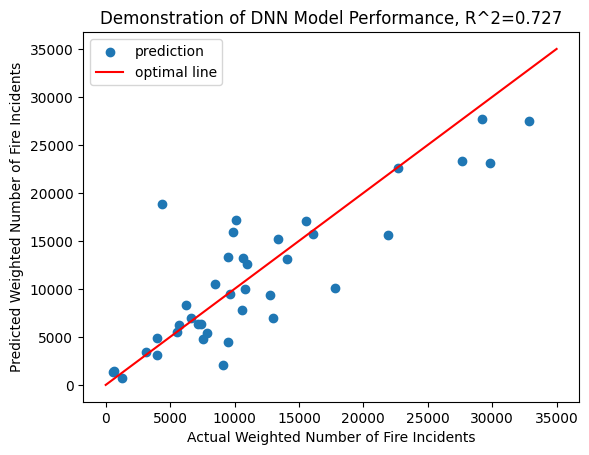

In [44]:
optimal_model = build_and_compile_model(normalizer, 30, 50)
optimal_model.fit(X_train, y_train, validation_split=0.2, verbose=0, epochs=100)
R2 = round(metrics.r2_score(y_test, optimal_model.predict(X_test).flatten()), 3)
plt.scatter(y_test, optimal_model.predict(X_test).flatten(), label='prediction');
plt.plot([0, 35000], [0, 35000], color='red', label='optimal line');
plt.xlabel('Actual Weighted Number of Fire Incidents');
plt.ylabel('Predicted Weighted Number of Fire Incidents');
plt.title(f'Demonstration of DNN Model Performance, R^2={R2}');
plt.legend();